# Урок 8. GAN



## Домашнее задание

1.   Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.</li>   
    

*   *вариант для 1) Обучите VAE на fashion_mnist 
*   *вариант для 1) Обучите GAN на одном классе CIFAR
*   *вариант для 1) обучите классификатор на данных tfds (Kaggle, UCI)
*   *вариант для 1) обучите семантическую сегментацию на tfds (Kaggle, UCI)

   
2.    Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на 
курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике? 

### Задание 1

Обучение GAN на одном классе CIFAR

#### Подключение библиотек

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

import os
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

#### Загрузка данных

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_num = 0
batch_size = 32
indices_train = np.where(y_train == class_num)
indices_test = np.where(y_test == class_num)

all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255
indices_train = np.where(y_train == class_num)
indices_test = np.where(y_test == class_num)
all_digits = all_digits[indices_train,:,:]
all_digits = np.reshape(all_digits, (-1, 32, 32, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

print('all_digits shape:', all_digits.shape)

170508288/170498071 [==============================] - 3s 0us/step
all_digits shape: (30000, 32, 32, 1)


#### Построение модели

In [3]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 128)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                     

In [4]:
latent_dim = 64

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(32 * 32 * 64),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((32, 32, 64)),
        layers.Conv2DTranspose(64, (3, 3), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, (3, 3), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (32, 32), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 65536)             4259840   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 65536)             0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 64)       36928     
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      147712    
 ranspose)                                               

In [5]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # строим по нему фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собрали с реальным изображением в тензор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # добавляем шум
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # обучаем discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #выбрали случайный пример в скрытом пространстве
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # собрали метки реальных изображений
        misleading_labels = tf.zeros((batch_size, 1))

        # обучаем generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}


In [6]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=64):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


#### Обучение модели

In [7]:
epochs = 25

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.SGD(),
    g_optimizer=keras.optimizers.SGD(),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/25
938/938 [==============================] - 83s 71ms/step - d_loss: 0.5633 - g_loss: 0.8462
Epoch 2/25
938/938 [==============================] - 62s 66ms/step - d_loss: 0.2609 - g_loss: 2.1586
Epoch 3/25
938/938 [==============================] - 62s 66ms/step - d_loss: 0.0308 - g_loss: 4.9211
Epoch 4/25
938/938 [==============================] - 62s 66ms/step - d_loss: -0.0129 - g_loss: 9.8441
Epoch 5/25
938/938 [==============================] - 62s 66ms/step - d_loss: -0.0936 - g_loss: 16.8824
Epoch 6/25
938/938 [==============================] - 62s 66ms/step - d_loss: 0.2873 - g_loss: 3.0539
Epoch 7/25
938/938 [==============================] - 61s 65ms/step - d_loss: 0.1054 - g_loss: 4.9827
Epoch 8/25
938/938 [==============================] - 62s 66ms/step - d_loss: 0.4701 - g_loss: 1.6932
Epoch 9/25
938/938 [==============================] - 62s 66ms/step - d_loss: 0.5950 - g_loss: 0.9245
Epoch 10/25
938/938 [==============================] - 61s 66ms/step - d_loss: 

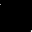

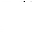

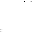

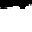

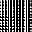

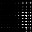

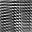

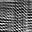

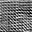

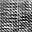

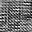

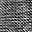

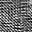

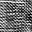

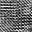

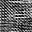

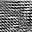

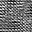

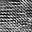

In [8]:
from IPython.display import Image, display

for i in range(1,20):
  display(Image("generated_img_0_"+str(i)+".png"))

#### Вывод


В улучшении  работы сети помогли следующие параметры: latent_dim равный 64, 25 эпох, оптимизатор SGD


### Задание 2

Modeling Long- and Short-Term Temporal Patterns with Deep Neural Networks

https://arxiv.org/pdf/1703.07015.pdf

Рекурентная модель с пропуском слоя, которая настроена так, чтобы учитывать переодичность данных. Оказалось, что во многих временных рядах есть ситуации, которые плохо моделируются нелинейными моделями глубокого обучения. В статье приводится описание адаптации архитектуры с помощью традиционной линейной модели - авторегрессии (AR). Итоговая модель LSTNet, комбинировала выходы модели AR и модели с обычным рекурентным слоем и параллельным пропуском рекурентного слоя.

Выходные данные сверточного слоя передаются recurent-skip компоненту. Закрытый рекуррентный нейрон разворачивается через q временных шагов. Выходы от развернутых нейронов, разделенных заранее заданным временным интервалом (сезонным периодом), позже используются в сети. На практике рекурентные нейроны не фиксируют долгосрочные зависимости. При прогнозировании потребления электроэнергии измерения за предыдущий день могут быть очень полезными предикторами. Введя пропуск подключений с интервалом в 24 часа, авторы гарантируют, что модель может использовать эти исторические зависимости.